## Import Tools 

In [6]:
#Initial load
from RedDownloader import RedDownloader
import praw
import requests
import re
import os
import urllib.request
from PIL import Image
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
import sys
import sklearn
from torchvision import datasets, transforms, utils
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score, train_test_split
from scipy.stats import uniform
import random



### Set up Reddit credentials

In [7]:
reddit = praw.Reddit(
    client_id = "qK4Xv6veQzln_8kyWjqbSw",
    client_secret = "bvzcM1BI3Lv3vWAj4UmWU2GNjs1VIw",
    username = "AllHailAI",
    password = "ChrisSebChris",
    user_agent = "Test"
)

subreddit = reddit.subreddit('EarthPorn')
top = subreddit.top()




In [6]:
## Iterate through top pictures in subreddit. Can't download pictures from deleted accounts. Those are skipped
n_pictures = 200

submission_ids = []
upvote_ratio = []
upvote = []
channels = []

for submission in subreddit.top(limit = n_pictures):
    if submission.url.endswith('.jpg') or submission.url.endswith('.png'):

        try:
            urllib.request.urlretrieve(submission.url, "./Data/{filename}".format(filename = f"{submission.id}.{submission.url.split('.')[-1]}"))
            img = Image.open("./Data/{filename}.jpg".format(filename = submission.id))
            img = img.resize((224,224))

            img.save("./Data/{filename}.jpg".format(filename = submission.id))

            submission_ids.append(submission.id)
            upvote_ratio.append(submission.upvote_ratio)
            upvote.append(submission.score)
            channels.append(len(img.getbands()))

        except:
            pass

In [7]:
df = pd.DataFrame({'submission_id':submission_ids, "upvote_ratio":upvote_ratio, "upvote": upvote, "channels":channels})

print(df.head())

  submission_id  upvote_ratio  upvote  channels
0        7t0swm          0.93  104581         3
1        6t89rv          0.95   90654         3
2        8e4djh          0.94   88878         3
3        cshcdu          0.96   85088         3
4        6vkdh8          0.78   84359         3


In [8]:
random.seed(420)

# Normalize to mean and std of ImageNet
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),  
    ]
)


### Define CNN for classification

In [9]:

#Define CNN
learning_rate = 1e-4
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()

    
    #Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)

    #Define pooling layers
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride = 2)


    #Define fully connected layers
        self.fc1 = nn.Linear(128*28*28,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,1)

    #Dropout some neurons to prevent overfitting.
        self.dropout = nn.Dropout(0.5)

    #Define activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


#Apply convolutional layers with pooling in between
    def forward(self, x):
        x = self.max_pool(nn.functional.relu(self.conv1(x)))
        x = self.max_pool(nn.functional.relu(self.conv2(x)))
        x = self.max_pool(nn.functional.relu(self.conv3(x)))

#Flatten output
        x = x.view(-1, 128*28*28)

        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        return x

model = Model()
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


### Load data 

In [10]:


data_path = "./Data"
filenames = df.submission_id
upvote_ratio = df.upvote_ratio

train_ids, test_ids, train_upvoteratios, test_upvoteratios = train_test_split(filenames, upvote_ratio, test_size=0.2, random_state = 42)

train_data = [(os.path.join(data_path, train_id + '.jpg'), train_upvoteratio) for train_id, train_upvoteratio in zip(train_ids, train_upvoteratios)]
test_data = [(os.path.join(data_path, test_id + '.jpg'), test_upvoteratio) for test_id, test_upvoteratio in zip(test_ids, test_upvoteratios)]

print(train_data)

print(len(train_data))
print(len(test_data))

NameError: name 'df' is not defined

In [11]:
class Loader(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        path, label = self.data[index]
        img = self.transform(Image.open(path))

        return img, label


train_dataset = Loader(train_data, transform=transform)
test_dataset = Loader(test_data, transform=transform)




NameError: name 'train_data' is not defined

In [74]:
print('Model parameters:')
for name, param in model.named_parameters():
    print(f'{name}: {param.shape}')
    print(f'Gradient: {param.grad.shape}')

Model parameters:
conv1.weight: torch.Size([32, 3, 3, 3])


AttributeError: 'NoneType' object has no attribute 'shape'

### Train CNN 

In [12]:
# Train loop

batch_size = 10
num_epochs = 10
learning_rate = 1e-4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def CNN(learning_rate=learning_rate, batch_size= batch_size,num_epochs= num_epochs):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for i, (images, ratio) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, ratio.float())
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        #train_losses.append(loss.item())

        # Test the model
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += loss_fn(output, target).item()
            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)
                
        test_losses.append(test_loss)
        
        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs, avg_train_loss, avg_test_loss))

    print("Finished training.")
        
    return model, train_losses, test_losses

model, train_losses, test_losses = CNN(learning_rate=1e-4, batch_size=10, num_epochs=10)




    

NameError: name 'train_dataset' is not defined

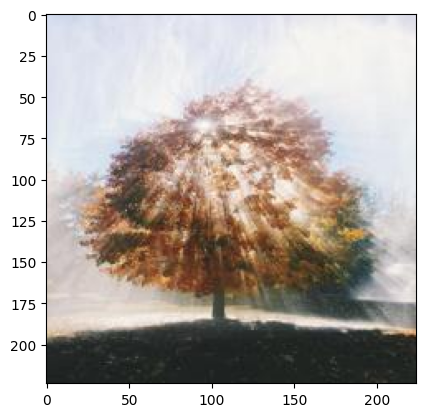

Iteration 0: Loss=1.035283088684082


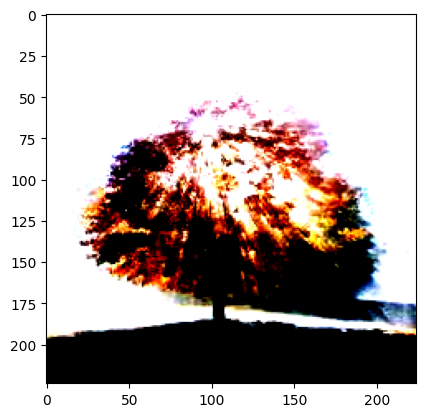

Iteration 100: Loss=1.0030596256256104


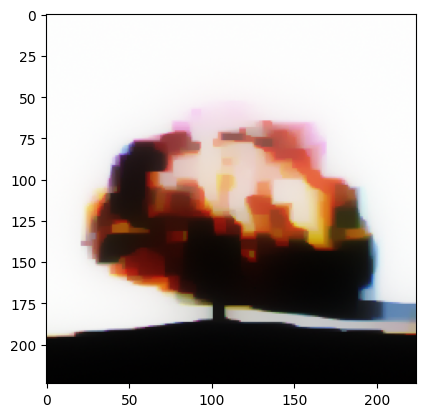

Iteration 200: Loss=1.002193570137024


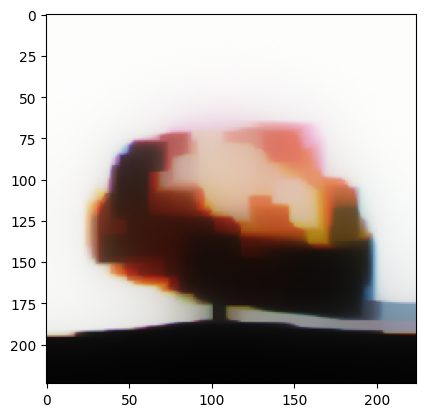

Iteration 300: Loss=1.0017266273498535


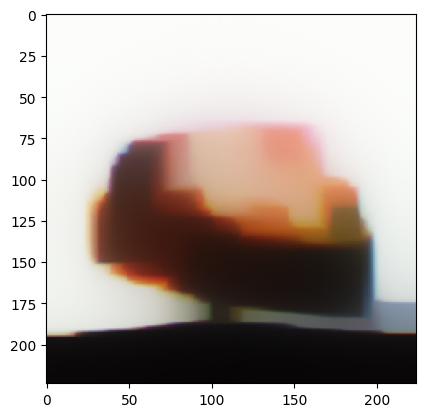

Iteration 400: Loss=1.001418948173523


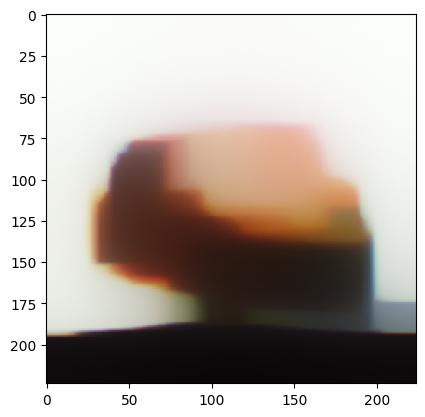

Iteration 500: Loss=1.0012333393096924


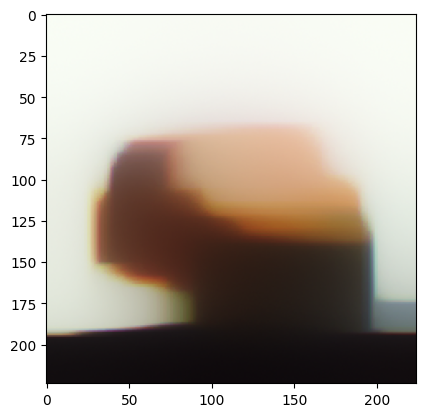

Iteration 600: Loss=1.0010831356048584


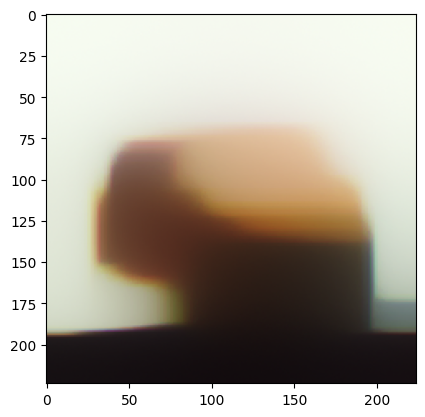

Iteration 700: Loss=1.0009342432022095


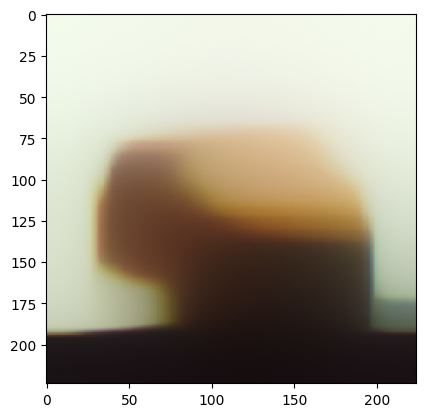

Iteration 800: Loss=1.000769019126892


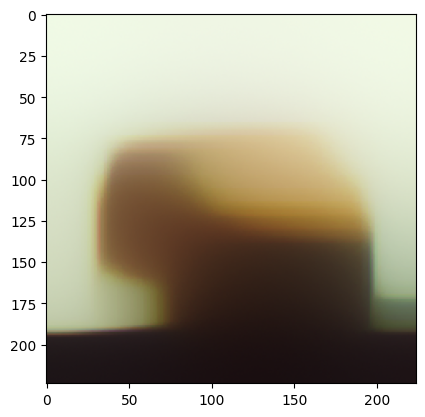

In [79]:
# Choose a random image and normalize it
image = Image.open("{}/{}".format(data_path, "5ceg1q.jpg"))

plt.imshow(image)
plt.show()

image_tensor = transform(image).unsqueeze(0)
img = image_tensor.clone().detach().requires_grad_(True)


# Set up the optimizer
optimizer = optim.Adam([img.requires_grad_()], lr=1e-2)

# Define the target output (near zero)
target = torch.tensor([[0]]).float()

# Run the optimization loop
tv_weight = 1e-6
for i in range(1000):
    optimizer.zero_grad()
    output = model(img)
    loss = criterion(output, target) + tv_weight * torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + tv_weight * torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    loss.backward()
    optimizer.step()
    
    # Clip the pixel values to stay within [0, 1] range
    img.data = torch.clamp(img.data, 0, 1)
    
    # Print the loss every 100 iterations
    if i % 100 == 0:
        print("Iteration {}: Loss={}".format(i, loss.item()))
        plt.imshow(img.squeeze().permute(1, 2, 0).detach().numpy())
        plt.show()

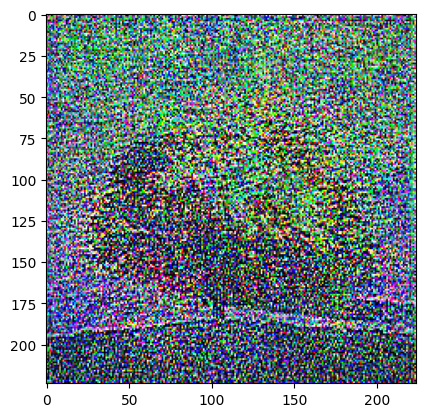

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img.squeeze().permute(1, 2, 0).detach().numpy())
plt.show()

### Predicting amount of upvotes

In [1]:
# Assuming you have the trained model saved as 'model.pth'
model_path = 'model.pth'

# Load the trained model
model = Model()
model.load_state_dict(torch.load(model_path))
model.eval()

# Preprocess the input image
input_image = Image.open('path_to_input_image.jpg')
input_image = input_image.resize((224, 224))
input_tensor = transform(input_image).unsqueeze(0)

# Pass the image through the model
with torch.no_grad():
    output = model(input_tensor)

# Interpret the predicted output
predicted_upvotes = output.item()
print("Predicted upvotes:", predicted_upvotes)


NameError: name 'Model' is not defined

### Feature highlighter

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Assuming you have the trained model saved as 'model.pth'
model_path = 'model.pth'

# Load the trained model
model = Model()
model.load_state_dict(torch.load(model_path))
model.eval()

# Preprocess the input image
input_image = Image.open('path_to_input_image.jpg')
input_image = input_image.resize((224, 224))
input_tensor = transform(input_image).unsqueeze(0)

# Set the model to evaluation mode and disable gradients
model.eval()
input_tensor.requires_grad_()

# Forward pass to obtain the output
output = model(input_tensor)

# Calculate the gradients of the output with respect to the input
output.backward()

# Get the gradients from the input tensor
gradients = input_tensor.grad[0]

# Convert the gradients to grayscale
grayscale_gradients = np.abs(gradients.numpy()).mean(axis=0)

# Normalize the gradients
normalized_gradients = (grayscale_gradients - np.min(grayscale_gradients)) / (
    np.max(grayscale_gradients) - np.min(grayscale_gradients)
)

# Plot the original image and the saliency map
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].axis('off')
axes[0].set_title('Input Image')
axes[1].imshow(normalized_gradients, cmap='hot')
axes[1].axis('off')
axes[1].set_title('Saliency Map')
plt.tight_layout()
plt.show()


Tanker vi kan køre på

Neural Style Transfer
To generate an image that carries over some of the features learned by the network, you can try a technique called "neural style transfer". Neural style transfer involves combining the style of one image with the content of another image using deep neural networks. This technique can be used to generate images that resemble a particular style, while still retaining some of the features of the original content.